<a href="https://colab.research.google.com/github/BSteiner1/MultiDeepQLearn/blob/main/Notebooks/DeepQEvolutionaryGame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import random
import matplotlib.pyplot as plt

### Demand Update Rule

In [77]:
# Function to calculate the demand for a given product
def evolutionary_demand(state):

  price1, price2, demand1, demand2 = state

  # Update Rule
  demand1 = demand1 + 0.5*(price2 - price1)
  demand2 = demand2 + 0.5*(price1 - price2)

  return demand1, demand2

### Decaying Epsilon-Greedy Action Selection

In [61]:
def epsilon_greedy_action_selection(net, state, t):
    if np.random.rand() < np.exp(-0.0002*t):
        # Exploration
        return random.choice([i for i in range(num_prices)])
    else:
        # Exploitation
        with torch.no_grad():
            q_values = net(state)
            return q_values.argmax().item()

### Determine profits from current prices and demands

In [62]:
def simulate_environment(prices_and_demands):
    price1, price2, demand1, demand2 = prices_and_demands

    # Calculate the revenue and profit for each product
    revenue1 = price1 * demand1
    revenue2 = price2 * demand2

    # Calculate profits
    profit1 = revenue1 - demand1 * 57
    profit2 = revenue2 - demand2 * 71

    return [profit1, profit2]

### Discretise the action space

In [63]:
# Number of prices to choose from
num_prices = 20
price_options = [(50 + 5*i) for i in range(1, num_prices+1)]

### Define parameters in the learning process

In [64]:
num_episodes = 30000
# Back Propagation learning rate
learning_rate = 0.001
# Q-Value update rule learning rate
q_learning_rate = 0.1
discount_factor = 0.96
max_steps_per_episode = 25

### Dimensions of the network

In [65]:
# Size of state (prices and demands)
state_size = 4
# Size of the hidden layer
hidden_size = 128
# Number of price options
action_size = num_prices

net_dimensions = [state_size, hidden_size, action_size]

### Training Loop

In [68]:
def train_q_learning(num_episodes, learning_rate, q_learning_rate, discount_factor, max_steps_per_episode, net_dimensions):

    # Assign network dimensions
    state_size, hidden_size, action_size = net_dimensions

    #Create the Q-value models for each agent
    q_value_model_agent1 = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
    )
    q_value_model_agent2 = nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size)
    )

    optimizer_agent1 = optim.Adam(q_value_model_agent1.parameters(), lr=learning_rate)
    optimizer_agent2 = optim.Adam(q_value_model_agent2.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    profit1, profit2 = [], []

    start_time = time.time()

    for episode in range(num_episodes):
      if episode%5000 == 0:
        print("Episode: ", episode)

      episode_actions, episode_profit1, episode_profit2 = [], 0, 0

      # Initialise with random prices for both businesses
      demand1, demand2 = 200, 200

      # Initialise the price at marginal cost
      price1, price2 = 57, 71

      # Initialise the state
      state = torch.tensor([price1, price2, demand1, demand2], dtype=torch.float32)

      # Update profit
      episode_profit1 += simulate_environment(state)[0]
      episode_profit2 += simulate_environment(state)[1]

      for _ in range(max_steps_per_episode-1):

        # Update demands
        demand1, demand2 = evolutionary_demand(state)

        # Update state
        state = torch.tensor([price1, price2, demand1, demand2], dtype=torch.float32)

        # Agent 1 chooses action based on the current state and epsilon-greedy strategy
        action_agent1 = epsilon_greedy_action_selection(q_value_model_agent1, state, episode)
        #episode_actions.append(action_agent1)

        # Agent 2 chooses action based on the current state and epsilon-greedy strategy
        action_agent2 = epsilon_greedy_action_selection(q_value_model_agent2, state, episode)

        # Update prices
        price1, price2 = price_options[action_agent1], price_options[action_agent2]

        # Simulate the environment based on the joint action and calculate profit
        rewards = simulate_environment(state)
        episode_profit1 += rewards[0]
        episode_profit2 += rewards[1]

        # Calculate the Q-value target for the current state-action pair
        with torch.no_grad():
            q_value_target_agent1 = (1 - q_learning_rate) * q_value_model_agent1(state)[action_agent1] + \
                                    q_learning_rate * (rewards[0] + discount_factor * torch.max(q_value_model_agent1(state)))

            q_value_target_agent2 = (1 - q_learning_rate) * q_value_model_agent2(state)[action_agent2] + \
                                    q_learning_rate * (rewards[1] + discount_factor * torch.max(q_value_model_agent2(state)))

        # Calculate the Q-value prediction for the current state-action pair
        q_value_prediction_agent1 = q_value_model_agent1(state)[action_agent1]
        q_value_prediction_agent2 = q_value_model_agent2(state)[action_agent2]

        # Update the Q-values for the chosen actions using the Q-value targets
        q_value_model_agent1(state)[action_agent1] = q_value_target_agent1
        q_value_model_agent2(state)[action_agent2] = q_value_target_agent2

        # Compute the loss and perform backpropagation for each agent
        optimizer_agent1.zero_grad()
        loss_agent1 = criterion(q_value_prediction_agent1, q_value_target_agent1)
        loss_agent1.backward()
        optimizer_agent1.step()

        optimizer_agent2.zero_grad()
        loss_agent2 = criterion(q_value_prediction_agent2, q_value_target_agent2)
        loss_agent2.backward()
        optimizer_agent2.step()

      profit1.append(episode_profit1)
      profit2.append(episode_profit2)

    end_time = time.time()
    elapsed_time = end_time - start_time
    time_per_episode = elapsed_time/num_episodes
    print("Total Number of Episodes:", num_episodes)
    print(f"Elapsed Time: {elapsed_time:.2f} seconds")
    print(f"Average Time per Episode: {time_per_episode:.3f} seconds")

    return q_value_model_agent1, q_value_model_agent2, profit1, profit2

In [69]:
trained_model_agent1, trained_model_agent2, profit1, profit2 = train_q_learning(num_episodes, learning_rate, q_learning_rate, discount_factor, max_steps_per_episode, net_dimensions)

Episode:  0
Episode:  5000
Episode:  10000
Episode:  15000
Episode:  20000
Episode:  25000
Total Number of Episodes: 30000
Elapsed Time: 1573.95 seconds
Average Time per Episode: 0.052 seconds


### Visualise the learning process

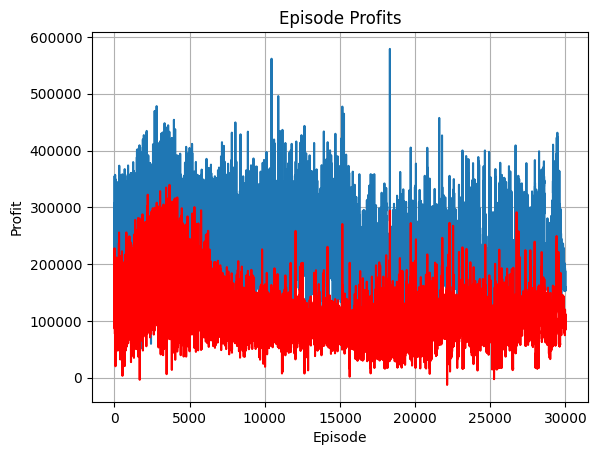

In [71]:
episodes = range(len(profit1))

plt.plot(episodes, profit1, label='Agent 1')
plt.plot(episodes, profit2, color='red', label='Agent 2')

plt.xlabel('Episode')
plt.ylabel('Profit')
plt.title('Episode Profits')
plt.grid(True)
plt.show()

### Play the agents against each other in a one-off game

In [72]:
def play_agents(agent1_model, agent2_model, max_iterations):

    prices1, prices2, demand_agent1, demand_agent2 = [], [], [], []
    profit1, profit2 = 0, 0

    # Start with price = marginal cost
    price_agent1, price_agent2 = 57, 71

    # Initial demands
    demand1, demand2 = 200, 200

    # Append prices and demands to history
    prices1.append(price_agent1)
    prices2.append(price_agent2)
    demand_agent1.append(demand1)
    demand_agent2.append(demand2)

    # Initial state
    state = torch.tensor([price_agent1, price_agent2, demand1, demand2], dtype = torch.float32)

    # Record profit
    p1, p2 = simulate_environment(state)
    profit1 += p1
    profit2 += p2

    for _ in range(max_iterations-1):

        # Update and record demands
        demand1, demand2 = evolutionary_demand(state)
        demand_agent1.append(int(demand1.item()))
        demand_agent2.append(int(demand2.item()))

        # Update the demands in the state tensor
        state = torch.tensor([price_agent1, price_agent2, demand1, demand2], dtype=torch.float32)

        # Update Step
        # Get the Q-values for both agents from their models
        q_values_agent1 = agent1_model(state)
        q_values_agent2 = agent2_model(state)

        # Choose action based on the learned policy
        action_agent1 = torch.argmax(q_values_agent1).item()
        action_agent2 = torch.argmax(q_values_agent2).item()

        # Get the price from the action
        price_agent1 = price_options[action_agent1]
        price_agent2 = price_options[action_agent2]

        # Keep track of price history
        prices1.append(price_agent1)
        prices2.append(price_agent2)

        # Update the prices in the state tensor
        state = torch.tensor([price_agent1, price_agent2, demand1, demand2], dtype=torch.float32)

        # Calculate and record profit
        p1, p2 = simulate_environment(state)
        profit1 += p1
        profit2 += p2

    return prices1, prices2, demand_agent1, demand_agent2, profit1, profit2

In [73]:
# Repetitions in each game
max_iterations = 25

### Outcome of the game

In [74]:
# Play the agents against each other and observe the equilibrium prices
agent1_prices, agent2_prices, demand_agent1, demand_agent2, agent1_profit, agent2_profit = play_agents(trained_model_agent1, trained_model_agent2, max_iterations)

In [75]:
print("Agent 1 Prices: ", agent1_prices)
print("Agent 1 Demand: ", demand_agent1)
print("\nAgent 2 Prices: ", agent2_prices)
print("Agent 2 Demand: ", demand_agent2)
print("\nAgent 1 Profit: ", agent1_profit.item())
print("Agent 2 Profit: ", agent2_profit.item())

Agent 1 Prices:  [57, 75, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90]
Agent 1 Demand:  [200, 207, 209, 204, 199, 194, 197, 199, 202, 204, 207, 209, 212, 214, 217, 219, 222, 224, 219, 214, 209, 204, 199, 194, 197]

Agent 2 Prices:  [71, 80, 80, 80, 80, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 80, 80, 80, 80, 80, 80, 95, 95]
Agent 2 Demand:  [200, 193, 190, 195, 200, 205, 203, 200, 198, 195, 193, 190, 188, 185, 183, 180, 178, 175, 180, 185, 190, 195, 200, 205, 203]

Agent 1 Profit:  161334.0
Agent 2 Profit:  82195.5


### A function to inspect the next price Player 1 will set

In [59]:
def inspect_agent(price1, price2, demand1, demnd2):
  state_agent1 = torch.tensor([price1, price2, demand1, demnd2], dtype=torch.float32)

  # Get the Q-values for Agent 1 in state
  q_values_agent1 = trained_model_agent1(state_agent1)

  # Convert the Q-values tensor to a NumPy array for easier inspection
  q_values_agent1 = q_values_agent1.detach().numpy()

  print("Q-values for Agent 1 in state ", (price1, price2, demand1, demnd2), ":\n\n", q_values_agent1)

  # Select action with highest Q-value
  action = q_values_agent1.argmax()
  print("\nNext Action: ", price_options[action])

In [76]:
inspect_agent(90, 95, 200, 200)

Q-values for Agent 1 in state  (90, 95, 200, 200) :

 [159264.3  159267.53 158682.19 159275.52 157793.25 158840.23 159237.2
 163230.6  161033.61 157945.89 157600.64 158945.9  157123.39 156861.77
 152864.55 154592.3  158510.53 159141.72 158767.25 158753.2 ]

Next Action:  90
